In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:14 - loss: 0.1751 - STD: 1.2768e-04 - MAE: 0.4054

 4/64 [>.............................] - ETA: 1s - loss: 0.0621 - STD: 3.6362e-04 - MAE: 0.1887  

 8/64 [==>...........................] - ETA: 0s - loss: 0.0496 - STD: 2.2648e-04 - MAE: 0.1722

12/64 [====>.........................] - ETA: 0s - loss: 0.0446 - STD: 1.6385e-04 - MAE: 0.1648

15/64 [======>.......................] - ETA: 0s - loss: 0.0405 - STD: 1.4608e-04 - MAE: 0.1529

18/64 [=======>......................] - ETA: 0s - loss: 0.0360 - STD: 1.3916e-04 - MAE: 0.1382

22/64 [=========>....................] - ETA: 0s - loss: 0.0324 - STD: 1.3257e-04 - MAE: 0.1326

25/64 [==========>...................] - ETA: 0s - loss: 0.0305 - STD: 1.2743e-04 - MAE: 0.1303

26/64 [===========>..................] - ETA: 1s - loss: 0.0304 - STD: 1.2566e-04 - MAE: 0.1289

30/64 [=============>................] - ETA: 1s - loss: 0.0280 - STD: 1.1872e-04 - MAE: 0.1210

34/64 [==============>...............] - ETA: 0s - loss: 0.0264 - STD: 1.1245e-04 - MAE: 0.1139

37/64 [================>.............] - ETA: 0s - loss: 0.0253 - STD: 1.0893e-04 - MAE: 0.1096

40/64 [=================>............] - ETA: 0s - loss: 0.0244 - STD: 1.0663e-04 - MAE: 0.1062

43/64 [===================>..........] - ETA: 0s - loss: 0.0235 - STD: 1.0508e-04 - MAE: 0.1040

47/64 [=====================>........] - ETA: 0s - loss: 0.0227 - STD: 1.0397e-04 - MAE: 0.1023

50/64 [======================>.......] - ETA: 0s - loss: 0.0221 - STD: 1.0353e-04 - MAE: 0.1008

54/64 [========================>.....] - ETA: 0s - loss: 0.0214 - STD: 1.0329e-04 - MAE: 0.0985

58/64 [==========================>...] - ETA: 0s - loss: 0.0208 - STD: 1.0351e-04 - MAE: 0.0961

61/64 [===========================>..] - ETA: 0s - loss: 0.0204 - STD: 1.0416e-04 - MAE: 0.0947

64/64 [==============================] - 3s 34ms/step - loss: 0.0200 - STD: 1.0520e-04 - MAE: 0.0936 - val_loss: 0.0167 - val_STD: 9.8190e-05 - val_MAE: 0.0827


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0127 - STD: 1.3399e-04 - MAE: 0.0733

 4/64 [>.............................] - ETA: 1s - loss: 0.0124 - STD: 1.3946e-04 - MAE: 0.0729

 8/64 [==>...........................] - ETA: 0s - loss: 0.0125 - STD: 1.4613e-04 - MAE: 0.0720

11/64 [====>.........................] - ETA: 0s - loss: 0.0126 - STD: 1.5127e-04 - MAE: 0.0711

15/64 [======>.......................] - ETA: 0s - loss: 0.0127 - STD: 1.5938e-04 - MAE: 0.0707

18/64 [=======>......................] - ETA: 0s - loss: 0.0126 - STD: 1.6610e-04 - MAE: 0.0704

22/64 [=========>....................] - ETA: 0s - loss: 0.0127 - STD: 1.7617e-04 - MAE: 0.0706

26/64 [===========>..................] - ETA: 0s - loss: 0.0127 - STD: 1.8737e-04 - MAE: 0.0707

30/64 [=============>................] - ETA: 0s - loss: 0.0127 - STD: 1.9972e-04 - MAE: 0.0707

34/64 [==============>...............] - ETA: 0s - loss: 0.0127 - STD: 2.1357e-04 - MAE: 0.0704

38/64 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 2.2928e-04 - MAE: 0.0703

42/64 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 2.4748e-04 - MAE: 0.0702

46/64 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 2.6812e-04 - MAE: 0.0702

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.9203e-04 - MAE: 0.0702

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 3.1233e-04 - MAE: 0.0702

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 3.4393e-04 - MAE: 0.0702

61/64 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 3.8121e-04 - MAE: 0.0702

64/64 [==============================] - 1s 19ms/step - loss: 0.0126 - STD: 4.1354e-04 - MAE: 0.0702 - val_loss: 0.0166 - val_STD: 8.5802e-04 - val_MAE: 0.0788


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0122 - STD: 0.0012 - MAE: 0.0688

 4/64 [>.............................] - ETA: 1s - loss: 0.0128 - STD: 0.0013 - MAE: 0.0700

 8/64 [==>...........................] - ETA: 0s - loss: 0.0126 - STD: 0.0014 - MAE: 0.0701

12/64 [====>.........................] - ETA: 0s - loss: 0.0127 - STD: 0.0016 - MAE: 0.0698

16/64 [======>.......................] - ETA: 0s - loss: 0.0126 - STD: 0.0018 - MAE: 0.0696

20/64 [========>.....................] - ETA: 0s - loss: 0.0125 - STD: 0.0021 - MAE: 0.0694

23/64 [=========>....................] - ETA: 0s - loss: 0.0124 - STD: 0.0024 - MAE: 0.0693

27/64 [===========>..................] - ETA: 0s - loss: 0.0124 - STD: 0.0027 - MAE: 0.0690

31/64 [=============>................] - ETA: 0s - loss: 0.0123 - STD: 0.0032 - MAE: 0.0690

35/64 [===============>..............] - ETA: 0s - loss: 0.0122 - STD: 0.0039 - MAE: 0.0687

39/64 [=================>............] - ETA: 0s - loss: 0.0121 - STD: 0.0046 - MAE: 0.0682

43/64 [===================>..........] - ETA: 0s - loss: 0.0119 - STD: 0.0056 - MAE: 0.0677

47/64 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.0069 - MAE: 0.0673

51/64 [======================>.......] - ETA: 0s - loss: 0.0116 - STD: 0.0083 - MAE: 0.0666

54/64 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 0.0097 - MAE: 0.0660

58/64 [==========================>...] - ETA: 0s - loss: 0.0111 - STD: 0.0118 - MAE: 0.0651

62/64 [============================>.] - ETA: 0s - loss: 0.0108 - STD: 0.0142 - MAE: 0.0641

64/64 [==============================] - 1s 19ms/step - loss: 0.0107 - STD: 0.0155 - MAE: 0.0636 - val_loss: 0.0080 - val_STD: 0.0418 - val_MAE: 0.0535


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0457

 4/64 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0456

 8/64 [==>...........................] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0445

12/64 [====>.........................] - ETA: 0s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0436

15/64 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0736 - MAE: 0.0429

18/64 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0423

21/64 [========>.....................] - ETA: 0s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0417

24/64 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0412

28/64 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0812 - MAE: 0.0406

32/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0828 - MAE: 0.0401

36/64 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0843 - MAE: 0.0396

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0855 - MAE: 0.0391

44/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0866 - MAE: 0.0387

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0872 - MAE: 0.0384

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0881 - MAE: 0.0381

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0888 - MAE: 0.0377

59/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0895 - MAE: 0.0374

63/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0901 - MAE: 0.0372

64/64 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0902 - MAE: 0.0371 - val_loss: 0.0029 - val_STD: 0.0791 - val_MAE: 0.0359


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0323

 5/64 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1000 - MAE: 0.0325

 8/64 [==>...........................] - ETA: 0s - loss: 0.0023 - STD: 0.0999 - MAE: 0.0323

12/64 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.1000 - MAE: 0.0323

15/64 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0323

19/64 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0321

23/64 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1003 - MAE: 0.0320

27/64 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1003 - MAE: 0.0319

31/64 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0318

35/64 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0318

39/64 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0317

43/64 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0316

46/64 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0316

49/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1004 - MAE: 0.0315

53/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1006 - MAE: 0.0314

56/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1007 - MAE: 0.0314

59/64 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1008 - MAE: 0.0313

62/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1009 - MAE: 0.0313

64/64 [==============================] - 1s 19ms/step - loss: 0.0021 - STD: 0.1009 - MAE: 0.0313 - val_loss: 0.0025 - val_STD: 0.0883 - val_MAE: 0.0331


Epoch 6/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

 4/64 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0303

 7/64 [==>...........................] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0302

11/64 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0303

15/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0303

19/64 [=======>......................] - ETA: 0s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0303

23/64 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0302

26/64 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1020 - MAE: 0.0302

29/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1020 - MAE: 0.0302

33/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0302

37/64 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0302

41/64 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0301

44/64 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0301

48/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0301

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0300

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0300

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0300

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0300

64/64 [==============================] - 1s 19ms/step - loss: 0.0019 - STD: 0.1025 - MAE: 0.0300 - val_loss: 0.0024 - val_STD: 0.0894 - val_MAE: 0.0321


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0294

 5/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0294

 8/64 [==>...........................] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0294

11/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0293

14/64 [=====>........................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0293

18/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0292

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0293

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0292

29/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0292

33/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0292

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0291

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0291

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0291

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0290

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0290

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0290

64/64 [==============================] - 1s 19ms/step - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290 - val_loss: 0.0023 - val_STD: 0.0915 - val_MAE: 0.0312


Epoch 8/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0285

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0289

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0286

15/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0286

18/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0286

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0285

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0285

28/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0285

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0285

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0285

39/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

45/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0285

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

64/64 [==============================] - 1s 19ms/step - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283 - val_loss: 0.0022 - val_STD: 0.0883 - val_MAE: 0.0310


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0986 - MAE: 0.0292

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

 8/64 [==>...........................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

12/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0280

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

20/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

23/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

30/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0285

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

38/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

64/64 [==============================] - 1s 19ms/step - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287 - val_loss: 0.0021 - val_STD: 0.0908 - val_MAE: 0.0302


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0275

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

 8/64 [==>...........................] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0277

12/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

15/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0276

19/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0276

23/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

27/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0275

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276 - val_loss: 0.0021 - val_STD: 0.0923 - val_MAE: 0.0300


Epoch 11/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0272

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0275

12/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0276

15/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0274

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0274

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0274

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0273

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0273

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272 - val_loss: 0.0021 - val_STD: 0.0949 - val_MAE: 0.0297


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0268

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0272

 8/64 [==>...........................] - ETA: 0s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0271

11/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0273

15/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0272

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270 - val_loss: 0.0022 - val_STD: 0.0956 - val_MAE: 0.0300


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

12/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

15/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0269

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

64/64 [==============================] - 1s 19ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269 - val_loss: 0.0020 - val_STD: 0.0926 - val_MAE: 0.0294


Epoch 14/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0269

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0267

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266 - val_loss: 0.0020 - val_STD: 0.0954 - val_MAE: 0.0293


Epoch 15/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

15/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

19/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - 1s 18ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0019 - val_STD: 0.0928 - val_MAE: 0.0293


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0265

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

64/64 [==============================] - 1s 18ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264 - val_loss: 0.0019 - val_STD: 0.0936 - val_MAE: 0.0289


Epoch 17/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

12/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

15/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0926 - val_MAE: 0.0289


Epoch 18/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0265

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263 - val_loss: 0.0019 - val_STD: 0.0953 - val_MAE: 0.0284


Epoch 19/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0252

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

11/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

64/64 [==============================] - 1s 18ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261 - val_loss: 0.0019 - val_STD: 0.0945 - val_MAE: 0.0285


Epoch 20/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0258

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0931 - val_MAE: 0.0284


Epoch 21/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0260

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

12/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259 - val_loss: 0.0021 - val_STD: 0.0961 - val_MAE: 0.0296


Epoch 22/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0265

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - 1s 18ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0941 - val_MAE: 0.0285


Epoch 23/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0252

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0260

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257 - val_loss: 0.0022 - val_STD: 0.0985 - val_MAE: 0.0300


Epoch 24/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0267

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0257

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0256

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0020 - val_STD: 0.0970 - val_MAE: 0.0290


Epoch 25/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0259

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

15/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

19/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254 - val_loss: 0.0020 - val_STD: 0.0966 - val_MAE: 0.0289


Epoch 26/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0256

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0267

 8/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0262

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

15/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

18/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - 1s 19ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257 - val_loss: 0.0018 - val_STD: 0.0896 - val_MAE: 0.0293


Epoch 27/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0279

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - 1s 19ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0017 - val_STD: 0.0946 - val_MAE: 0.0276


Epoch 28/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0251

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

12/64 [====>.........................] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

15/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

19/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

23/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

27/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256 - val_loss: 0.0019 - val_STD: 0.0963 - val_MAE: 0.0286


Epoch 29/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0253

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

15/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

18/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252 - val_loss: 0.0018 - val_STD: 0.0961 - val_MAE: 0.0277


Epoch 30/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1090 - MAE: 0.0251

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0250

10/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 1s 19ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258 - val_loss: 0.0023 - val_STD: 0.0987 - val_MAE: 0.0311


Epoch 31/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1102 - MAE: 0.0267

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0250

30/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0250

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

64/64 [==============================] - 1s 19ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251 - val_loss: 0.0017 - val_STD: 0.0912 - val_MAE: 0.0283


Epoch 32/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1002 - MAE: 0.0273

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252 - val_loss: 0.0017 - val_STD: 0.0948 - val_MAE: 0.0275


Epoch 33/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0247

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252 - val_loss: 0.0018 - val_STD: 0.0965 - val_MAE: 0.0276


Epoch 34/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0249

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

 8/64 [==>...........................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

11/64 [====>.........................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

64/64 [==============================] - 1s 19ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251 - val_loss: 0.0018 - val_STD: 0.0961 - val_MAE: 0.0276


Epoch 35/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0243

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

10/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

14/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

24/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

36/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

64/64 [==============================] - 1s 18ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248 - val_loss: 0.0019 - val_STD: 0.0975 - val_MAE: 0.0284


Epoch 36/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0247

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

20/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

24/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

36/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - 1s 18ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251 - val_loss: 0.0017 - val_STD: 0.0936 - val_MAE: 0.0275


Epoch 37/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0250

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

15/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

19/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

23/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

64/64 [==============================] - 1s 18ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249 - val_loss: 0.0018 - val_STD: 0.0970 - val_MAE: 0.0278


Epoch 38/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0244

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0245

 8/64 [==>...........................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

12/64 [====>.........................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

16/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

20/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

24/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - 1s 19ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0016 - val_STD: 0.0937 - val_MAE: 0.0270


Epoch 39/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0254

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0250

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0250

14/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

18/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

22/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

26/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

30/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

64/64 [==============================] - 1s 18ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246 - val_loss: 0.0018 - val_STD: 0.0964 - val_MAE: 0.0280


Epoch 40/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0240

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0249

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

19/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

23/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

27/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

39/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

64/64 [==============================] - 1s 18ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247 - val_loss: 0.0017 - val_STD: 0.0969 - val_MAE: 0.0277


Epoch 41/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0248

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0243

 7/64 [==>...........................] - ETA: 0s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0243

10/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

14/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0247

18/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

64/64 [==============================] - 1s 19ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247 - val_loss: 0.0019 - val_STD: 0.0972 - val_MAE: 0.0287


Epoch 42/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1113 - MAE: 0.0249

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

24/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

36/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

64/64 [==============================] - 1s 18ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246 - val_loss: 0.0021 - val_STD: 0.1004 - val_MAE: 0.0298


Epoch 43/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0253

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

 8/64 [==>...........................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

11/64 [====>.........................] - ETA: 0s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0248

15/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0250

19/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0249

23/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0248

27/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0247

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0246

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0246

39/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0246

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0247

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0247

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0247

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

64/64 [==============================] - 1s 18ms/step - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247 - val_loss: 0.0016 - val_STD: 0.0944 - val_MAE: 0.0271


Epoch 44/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1036 - MAE: 0.0242

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

 8/64 [==>...........................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0245

12/64 [====>.........................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0244

16/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

20/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244

23/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244

27/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0244

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245

64/64 [==============================] - 1s 18ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0245 - val_loss: 0.0018 - val_STD: 0.0974 - val_MAE: 0.0279


Epoch 45/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1081 - MAE: 0.0243

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0242

 8/64 [==>...........................] - ETA: 0s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0241

12/64 [====>.........................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0242

16/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

20/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

24/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

39/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

64/64 [==============================] - 1s 18ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247 - val_loss: 0.0018 - val_STD: 0.0957 - val_MAE: 0.0278


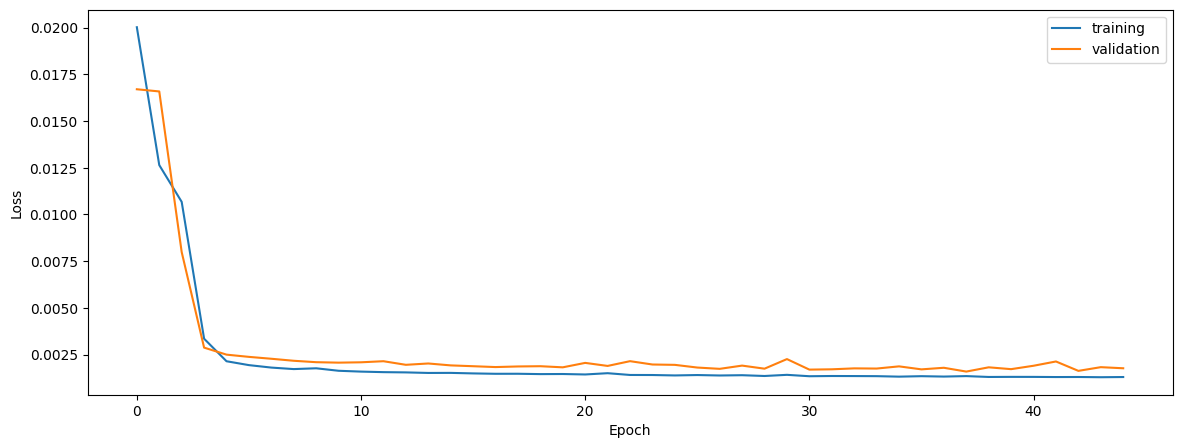

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9480744922454796
0.9523369174215116
0.9433191784650969


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9480744922454796
0.9523369174215116
0.9433191784650969


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9533160076749589
0.9562350491757661
0.9537452415087474


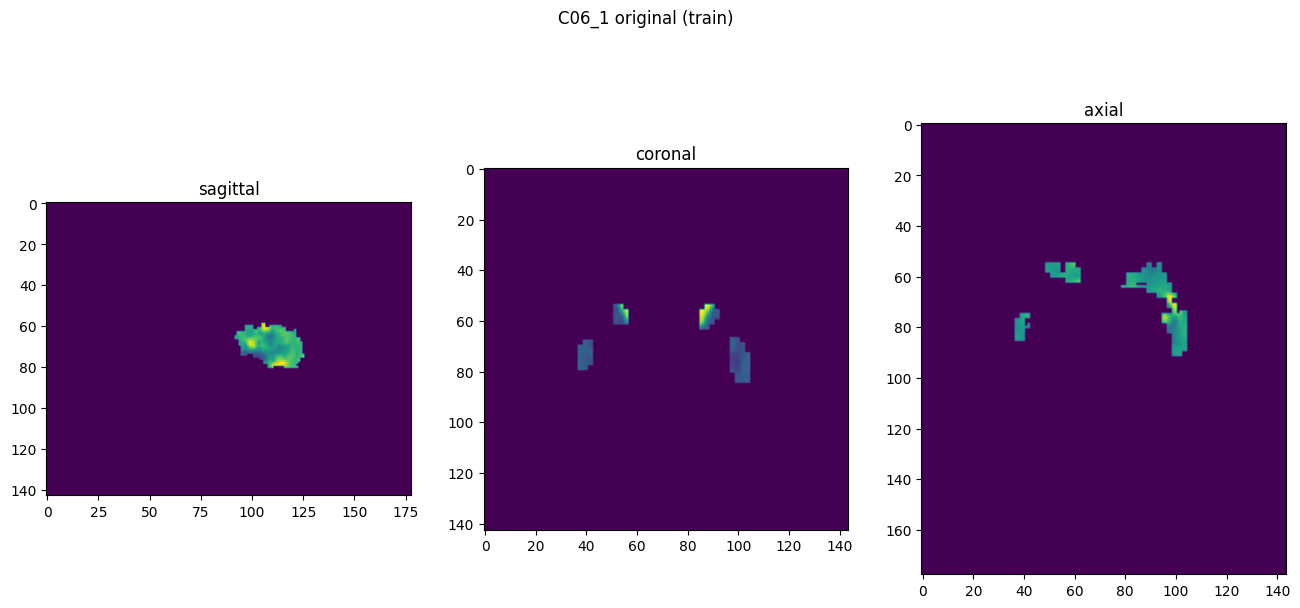

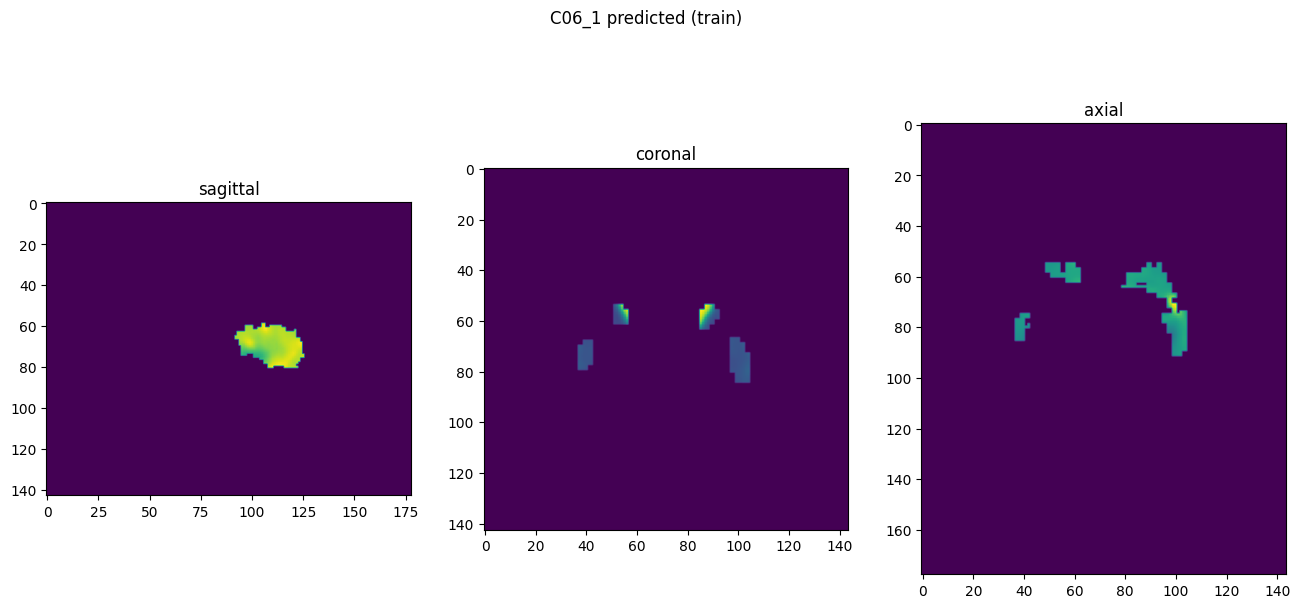

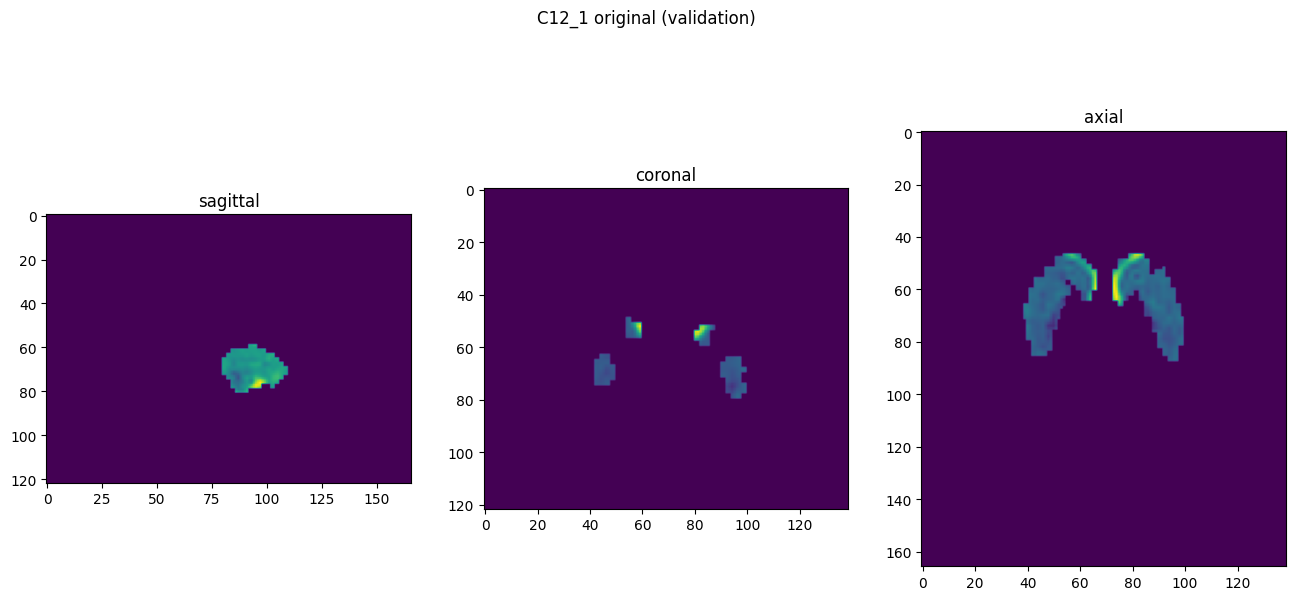

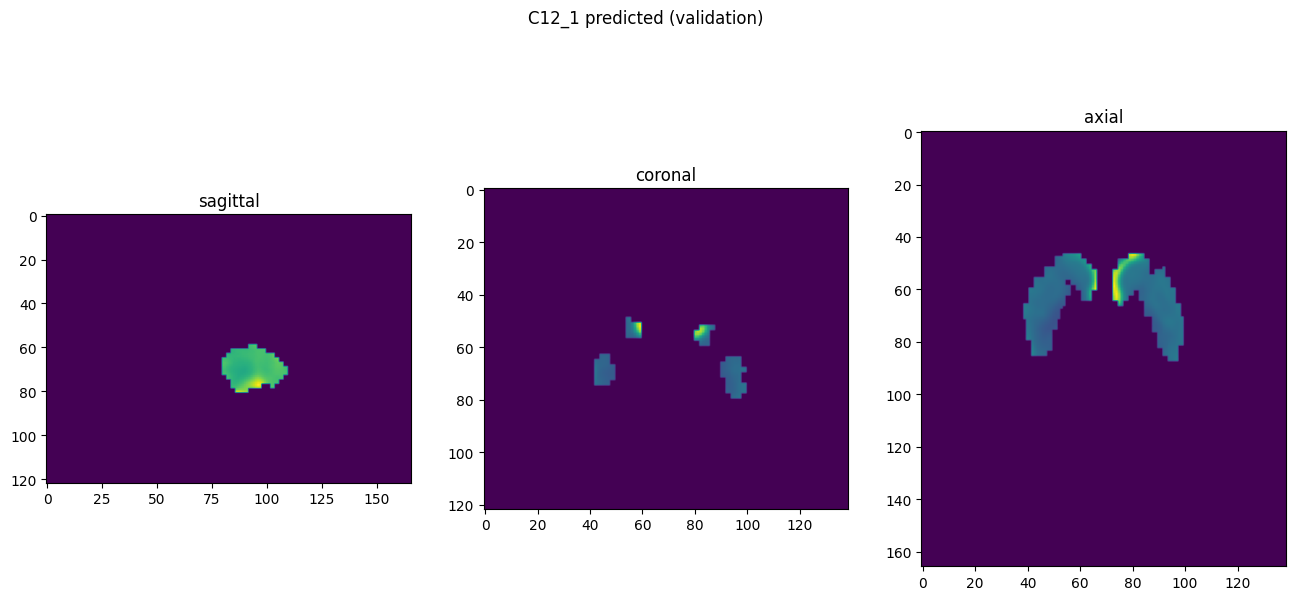

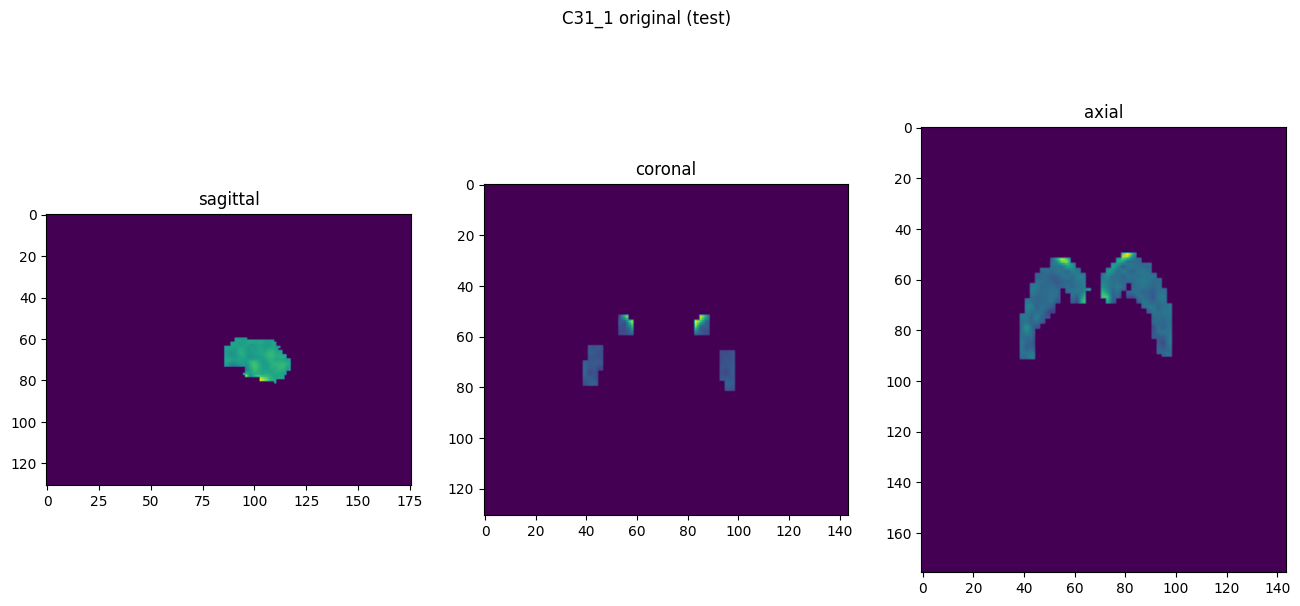

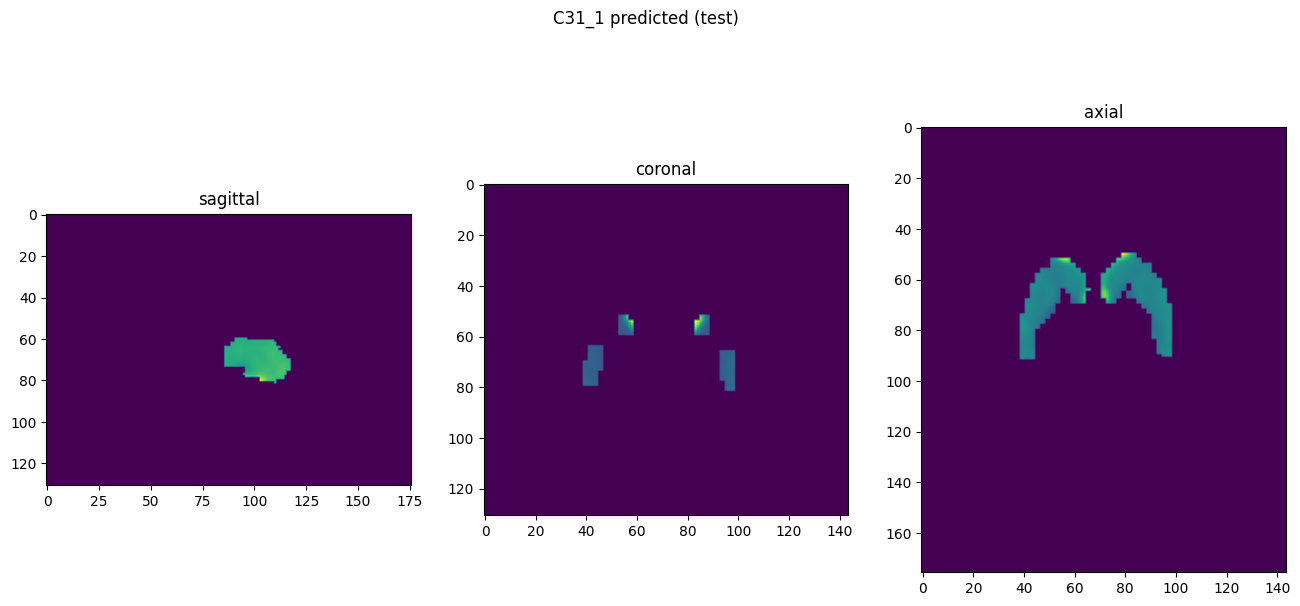

In [10]:
showResults(model, gen, threshold=None, background=False)